# Part V: Producción de un conjunto de datos distribuido.

Autores: Jordi Bolibar & Facundo Sapienza  
Traducción: Eduardo Villavicencio

```{note}
Antes de ejecutar este cuaderno, asegúrate de que el núcleo de Jupyter (en la esquina superior izquierda del cuaderno) esté configurado para trabajar con el entorno conda *finse_modelling*. 
```

## 5.1. Contexto

Como habrás notado, los datos de balance de masa geodésico a escala de glaciar utilizados en los cuadernos anteriores son extremadamente ruidosos. Además, el interés científico de dicho conjunto de datos es limitado en términos de predicción, ya que utilizamos deliberadamente un conjunto de datos simple para explicar el flujo básico de trabajo de aprendizaje automático. En general, los conjuntos de datos de teledetección tienen una muy buena cobertura espacial, pero una baja resolución temporal. El conjunto de datos real de [Hugonnet et al. (2021)](https://www.nature.com/articles/s41586-021-03436-z) consiste en rejillas raster con el balance de masa geodésico distribuido de cada glaciar en el mundo durante múltiples períodos. Esto significa que tenemos información adicional sobre el balance de masa espacial en lugar de un solo valor a escala de glaciar. Aprovechar estos datos puede ser muy interesante debido a la mayor riqueza de información.

Alternativamente, la [OGGM Shop](https://docs.oggm.org/en/stable/shop.html) también proporciona acceso a una amplia gama de conjuntos de datos de glaciares, que pueden ser utilizados para entrenar modelos de aprendizaje automático. Como se mostrará en este cuaderno, con solo unas pocas líneas de código podemos obtener todos los datos necesarios para una región de interés y comenzar a entrenar modelos de aprendizaje automático.

Aquí, proponemos dos proyectos más avanzados para aprovechar datos raster distribuidos espacialmente (es decir, en rejilla). Estos proyectos se pueden abordar con los métodos anteriores vistos en el Cuaderno 3, o para los más audaces, pueden intentar usar redes neuronales convolucionales para extraer la información espacial presente en los datos en rejilla. Estos cuadernos se basarán en gran medida en los increíbles recursos proporcionados por OGGM, particularmente en [este cuaderno orientado al aprendizaje automático](https://oggm.org/tutorials/stable/notebooks/10minutes/machine_learning.html) y [este nuevo tutorial sobre la obtención de conjuntos de datos de vanguardia](https://oggm.org/training-lahore/day_4/01_data_prep.html).

```{note}
En este cuaderno, adaptaremos el Cuaderno 1 para producir un conjunto de datos similar, pero de manera distribuida, es decir, en 2D, para que podamos modelar cada celda de la rejilla del glaciar en lugar de utilizar información a escala de glaciar.
```

## 5.2. Recomputación de un conjunto de datos distribuido.

In [1]:
import oggm
oggm.__version__

'1.6.0'

Importamos todas las dependencias necesarias para recuperar los datos con OGGM y para postprocesarlos. Utilizamos multiprocesamiento con OGGM para hacer las cosas más rápidas.

In [2]:
import xarray as xr
import numpy as np
import rioxarray
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm import entity_task, global_tasks
from oggm.utils import compile_climate_input
from oggm.core import gis
from oggm.utils import DEM_SOURCES
from pathlib import Path
import os
import logging
from datetime import datetime, timedelta

pd.set_option('display.max_columns',None)

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True 
cfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2024-09-24 16:55:54: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-09-24 16:55:54: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-09-24 16:55:54: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-09-24 16:55:54: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-09-24 16:55:54: oggm.cfg: Multiprocessing switched ON after user settings.
2024-09-24 16:55:54: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


Elige tu ruta de OGGM donde quieras almacenar todos los datos. Dado que todos estamos trabajando en el mismo Hub, podemos guardar la información en la misma carpeta compartida. Aquí usamos una carpeta diferente a la del cuaderno 1, especificando que se trata de datos distribuidos.

In [3]:
parent_path = os.getcwd () # Direccion del proyecto 
workspace_path = os.path.join(parent_path, 'OGGM_data_Finse_practic')
#workspace_path = '/home/jovyan/shared/glacier-ml-2022/Mass_Balance_ML_Modelling/Data'

if not os.path.exists(workspace_path):
    os.mkdir(workspace_path)

cfg.PATHS['working_dir'] = workspace_path

Como se hizo en el cuaderno 1, aquí creamos una nueva tarea de entidad para producir el conjunto de datos distribuido. Tanto los datos distribuidos como los datos climáticos están disponibles para cada directorio de glaciar en archivos netCDF, que leeremos y procesaremos utilizando `xarray`.

Reintroducimos la función auxiliar para convertir `datetimes` al formato correcto.

In [4]:
def decimal_to_datetime(ds):
    datetimes = []
    for dec_year in ds.time.data:
        year = int(dec_year)
        rem = dec_year - year

        base = datetime(year, 1, 1)
        calendar_time = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
        datetimes.append(calendar_time)
        
    climate_ds['time'] = datetimes
        
    return climate_ds

Y ahora declaramos la tarea de entidad real.

In [5]:
@entity_task(log)
def get_gridded_features(gdir):
    """Retrieves and processes gridded and climate data for a gdir in order to create the dataset
        to be fed to machine learning models.
    """
    # Retrieve gridded data
    with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
        gridded_ds = ds.load()
    # Retrieve climate data
    with xr.open_dataset(gdir.get_filepath('climate_historical')) as ds:
        climate_ds = ds.load()
        
    #### Latitude and Longitude 
    lon, lat = gdir.grid.ll_coordinates
    
    #### Climate data ####
    # First we start by processing the climate data
    # Trim climate dataset to desired period of the Hugonnet et al. (2021) dataset
    climate_ds = climate_ds.sel(time=slice('2000-01-01','2019-12-01')) 
    
    # Now we downscale the climate data to the specific glacier 
    # Temperature
    temps_2D = np.empty((climate_ds.temp.data.size, gridded_ds.topo.data.shape[0], gridded_ds.topo.data.shape[1]))
    i = 0
    for temp in climate_ds.temp.data:
        temps_2D[i,:,:] = np.tile(temp,gridded_ds.topo.data.shape) + 6.0/1000.0*(gridded_ds.topo.data - climate_ds.ref_hgt.data)
        i=i+1
    
    PDD_2D = np.sum(np.where(temps_2D > 0.0, temps_2D, 0.0), axis=0)
    
    # Rain
    rain_period_2D = np.empty((climate_ds.prcp.data.size, gridded_ds.topo.data.shape[0], gridded_ds.topo.data.shape[1]))
    i = 0
    for prcp in climate_ds.prcp.data:
        rain_period_2D[i,:,:] = np.tile(prcp,gridded_ds.topo.data.shape) 
        i=i+1
    
    rain_2D = np.sum(rain_period_2D, axis=0)
    
    # Snow
    snow_2D = np.sum(np.where(temps_2D < 0.0, rain_period_2D, 0.0), axis=0)
        
    # Ahora creamos un diccionario con el conjunto de datos completo, incluidos los datos climáticos anteriores
    # y todos los conjuntos de datos en cuadrícula
    training_data = {'lon': lon,
                     'lat': lat,
                     'PDD_2D': PDD_2D,
                     'rain_2D': rain_2D,
                     'snow_2D': snow_2D,
                     'topo': gridded_ds.topo.data,
                     'aspect': gridded_ds.aspect.data,
                     'slope': gridded_ds.slope.data,
                     'dis_from_border': gridded_ds.dis_from_border.data,
                     'glacier_mask': gridded_ds.glacier_mask.data,
                     'millan_ice_velocities': np.nan_to_num(gridded_ds.millan_v.data),
                     'millan_ice_thickness': np.nan_to_num(gridded_ds.millan_ice_thickness.data),
                     'hugonnet_dhdt': np.nan_to_num(gridded_ds.hugonnet_dhdt.data),
                     'ID': gdir.rgi_id
        }
    
    return training_data

Descargamos todos los datos de los glaciares en Low Latitudes (región RGI '16'). Utilizamos un directorio específico con datos preprocesados, que incluye todos los conjuntos de datos distribuidos que necesitamos.

In [6]:
rgi_region = '16' # Scandinavia
rgi_version = '6'
rgi_dir = utils.get_rgi_dir(version=rgi_version)
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)
# We use the directories with the shop data in it: "W5E5_w_data"
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/'
gdirs = workflow.init_glacier_directories(rgidf, from_prepro_level=3, prepro_base_url=base_url, prepro_border=10)

2024-09-24 16:56:28: oggm.workflow: init_glacier_directories from prepro level 3 on 2939 glaciers.
2024-09-24 16:56:29: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2939 glaciers


Añadamos algunos datos adicionales a todo eso.

In [7]:
# Tested tasks
task_list = [
    tasks.gridded_attributes,
    tasks.gridded_mb_attributes,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs, print_log=False)

2024-09-24 17:00:32: oggm.workflow: Execute entity tasks [gridded_attributes] on 2939 glaciers


2024-09-24 17:01:01: oggm.workflow: Execute entity tasks [gridded_mb_attributes] on 2939 glaciers


## 5.3. Exploración del conjunto de datos

Para tener una idea general de cómo se ve el dato, echaremos un vistazo rápido a los datos en rejilla que añadimos a nuestro conjunto de datos. Usaremos el archivo netCDF leído con `xarray`. Esto es diferente del conjunto de datos que hemos creado, ya que para ese solo mantuvimos datos en bruto como matrices, que es lo que se necesita para los modelos de aprendizaje automático. Echemos un vistazo al famoso Nigardsbreen.

In [12]:
for gdir in gdirs:
    if (gdir.name == 'arteson'):
        break

In [17]:
gdirs[0]

<oggm.GlacierDirectory>
  RGI id: RGI60-16.00001
  Region: 16: Low Latitudes
  Subregion: 16-01: Low-latitude Andes              
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 0.098 km2
  Lon, Lat: (-69.9053, -16.5212)
  Grid (nx, ny): (48, 46)
  Grid (dx, dy): (14.0, -14.0)

In [13]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
# List all variables
ds

<xarray.Dataset> Size: 413kB
Dimensions:                  (x: 81, y: 96)
Coordinates:
  * x                        (x) float32 324B -1.015e+03 -982.9 ... 1.545e+03
  * y                        (y) float32 384B -7.403e+04 ... -7.707e+04
Data variables: (12/17)
    topo                     (y, x) float32 31kB 4.597e+03 ... 5.113e+03
    topo_smoothed            (y, x) float32 31kB 4.592e+03 ... 5.136e+03
    topo_valid_mask          (y, x) int8 8kB 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 8kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 8kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 31kB nan nan nan nan ... nan nan nan
    ...                       ...
    glacier_ext_erosion      (y, x) int8 8kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    ice_divides              (y, x) int8 8kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    slope                    (y, x) float32 31kB 0.1134 0.1412 ... 0.2279 0.2291
    aspect                   (y, x) float32 31kB 5.594 5.401 ... 2.941 3.008
    slope_factor             (y, x) float32 31kB 3.691 3.237 ... 2.429 2.421
    dis_from_border          (y, x) float32 31kB 802.6 773.3 ... 1.397e+03
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=-78.4491 +k=0.9996 +x_0=0 +y_...
    max_h_dem:      5886.0
    min_h_dem:      4570.0
    max_h_glacier:  5883.0
    min_h_glacier:  4800.0

Podemos ver que hay una gran cantidad de datos disponibles aquí. Dado que estamos interesados en modelar el balance de masa distribuido, echaremos un vistazo a los datos de `hugonnet_dhdt`.

Primero, preparamos el mapa para comenzar a graficar los conjuntos de datos.

In [14]:
smap = ds.salem.get_map(countries=False)
smap.set_shapefile(gdir.read_shapefile('outlines'))
smap.set_topography(ds.topo.data);

Y ahora graficamos los datos de balance de masa geodésico de Hugonnet et al. (2021) para este glaciar:

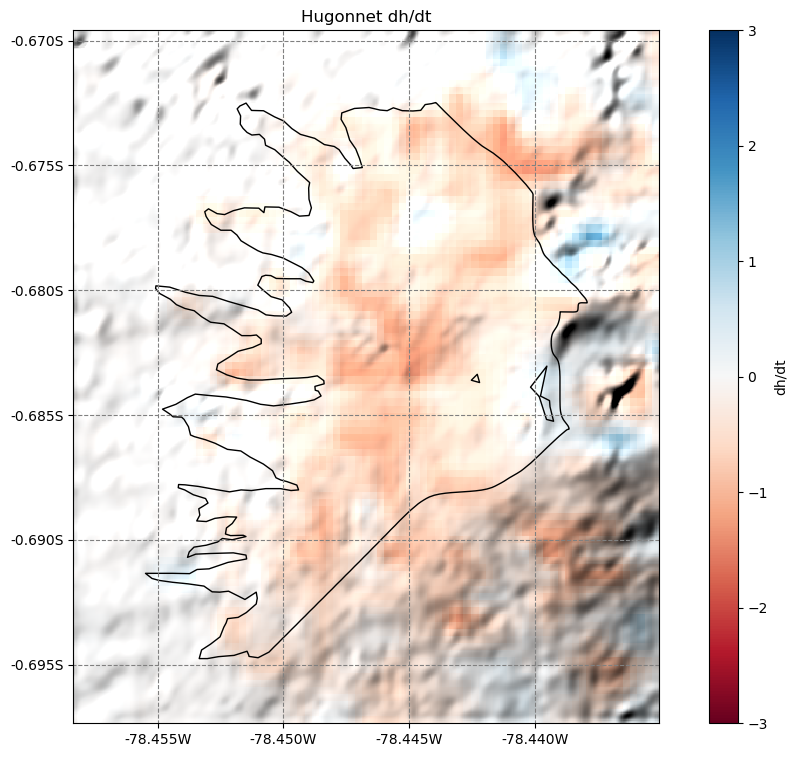

In [15]:
# get the axes ready
f, ax = plt.subplots(figsize=(9, 9))

smap.set_data(ds.hugonnet_dhdt)
smap.set_cmap('RdBu')
smap.set_plot_params(vmin=-3, vmax=3)
smap.plot(ax=ax)
smap.append_colorbar(ax=ax, label='dh/dt')

ax.set_title('Hugonnet dh/dt');

## 5.4. Creación del conjunto de datos de aprendizaje automático

Ahora podemos utilizar la tarea de entidad previamente declarada para crear el conjunto de datos de entrenamiento utilizando todos los datos en rejilla de interés para todos los glaciares en Escandinavia.

In [ ]:
training_data = workflow.execute_entity_task(get_gridded_features, gdirs)

Dado que hay algunos glaciares sin los datos requeridos, necesitamos eliminar algunos valores `None`.

In [ ]:
training_dict = np.delete(training_data, np.where(np.array(training_data) == None))

Y luego convertimos el array de numpy a una lista de Python, que luego puede convertirse en un `DataFrame` de pandas. Este `DataFrame` contiene todas las matrices con los datos de entrenamiento.

In [ ]:
df_training = pd.DataFrame.from_dict(training_dict.tolist())

Para perfeccionarlo, establecemos el ID RGI como el índice.

In [ ]:
df_training.index = df_training.ID
df_training.index.name = 'RGI_ID'
df_training = df_training.drop(columns='ID')
df_training.head(3)

In [ ]:
df_training.iloc[0].topo.shape, df_training.iloc[0].snow_2D.shape,

In [ ]:
df_training.to_csv("Data/df_distributed_training_raw.csv")

## 5.5. Versión aplanada del conjunto de datos

In [ ]:
def pd_ravel(row, key):
    res = row[key].ravel()
    return pd.DataFrame({key: res})

Número total de observaciones:

In [ ]:
res = 0
for i in range(df_training.shape[0]):
    df_rgi = df_training.iloc[i]
    res += df_rgi.PDD_2D.size
res

In [ ]:
df_rgi.PDD_2D.size

In [ ]:
rgi_list = []

for i in range(df_training.shape[0]):
    df_rgi = df_training.iloc[i]
    n_tot = df_rgi.PDD_2D.size
    print(n_tot)
    dict_rgi = {'RGI_ID': np.repeat(df_rgi.name, n_tot)}
    for key in df_training.columns:
        dict_rgi[key] = df_rgi[key].ravel()
        #print(key, df_rgi[key].ravel().size)
    df_rgi = pd.DataFrame(dict_rgi)
    rgi_list.append(df_rgi)

In [ ]:
len(rgi_list)

In [ ]:
df_all = pd.concat(rgi_list)

Finalmente, para evitar tener que ejecutar estas tareas computacionales costosas cada vez, guardamos el `DataFrame` en disco para usarlo más adelante.

In [ ]:
df_all

También filtramos solo aquellas columnas para las que tenemos hielo.

In [ ]:
df_all = df_all[df_all.glacier_mask==1]

In [ ]:
df_all.to_csv('Data/df_distributed_training.csv', index=False)

In [ ]:
df_training.shape